# This notebook features Collaborative filtering using matrix factorization*

## Loading in data

In [1]:
import pandas as pd
import numpy as np

In [2]:
user_item = pd.DataFrame(
    pd.read_csv('/home/grimoire/Projects/BeerRatings/user_item_matrix.csv', index_col='review_profilename'))

# Looking at the shape of our data (The user-item matrix)

In [3]:
user_item.shape

(3156, 13831)

## Transposing our matrix to item-user

In [4]:
X = user_item.values.T

In [5]:
# Verifying the transposition
X.shape

(13831, 3156)

## Working with Single Value Decomposition
* Visualizing explained error with n dimensions

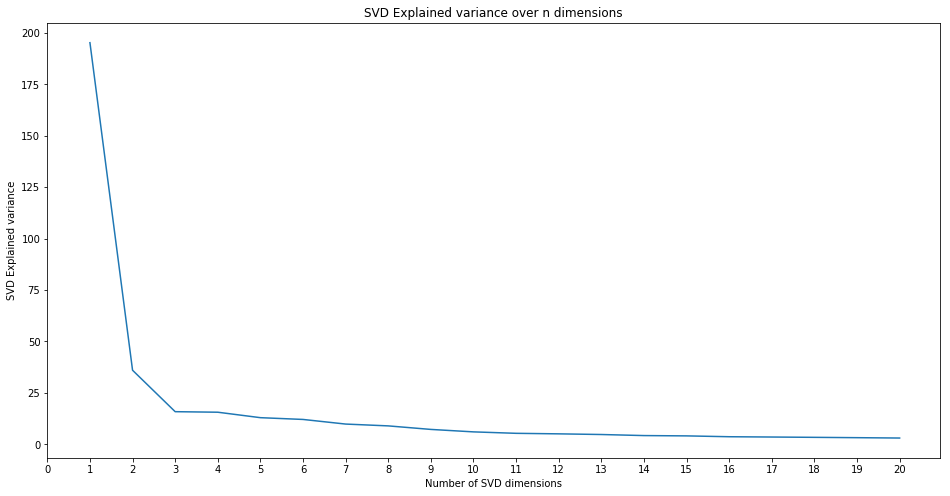

In [6]:
import matplotlib.pyplot as plt
% matplotlib inline
from sklearn.decomposition import TruncatedSVD

# Initialize a new PCA model with a default number of components.
svd = TruncatedSVD(n_components=20)
svd.fit(X)

plt.figure(figsize=[16,8])
plt.plot(range(1,len(svd.explained_variance_)+1), svd.explained_variance_)
plt.xticks(range(0,len(svd.explained_variance_)+1,1))

plt.title('SVD Explained variance over n dimensions')
plt.ylabel('SVD Explained variance')
plt.xlabel('Number of SVD dimensions')
plt.show()

## Parameter for n_components should be based upon model testing and evauluation

In [7]:
svd = TruncatedSVD(n_components=12, random_state=3)
matrix = svd.fit_transform(X)
matrix.shape

(13831, 12)

## Building our pearson coeffienct matrix using the transformed data matrix

In [8]:
import warnings
warnings.filterwarnings("ignore", category = RuntimeWarning)
corr = np.corrcoef(matrix)
corr.shape

(13831, 13831)

In [9]:
#############################################################
# The coeffecient matrix is an 2D array of arrays
# There is no indication of what columns refer to what beer
# We will pull this information from our user_item matrix
# Create a list of the beers from the columns
# The index of the list will correspond with the coefficient matrix
#############################################################

beer_names = user_item.columns
beer_name_list = list(beer_names)
len(beer_names)

13831

In [10]:
def recommendations(beer, beer_names=beer_names) :
    
    # https://stackoverflow.com/questions/944592/best-practice-for-python-assert
    # Self note: build an exception class for beer parameter
    
    assert beer in beer_names, 'The beer isn\'t currently in the recommendation list,\
 rate it more and it will be soon!' # This derives from user input not matching beer_names, add to exception class
    
    beer_name_list = list(beer_names) # Contains the index/name of the beer
    beer_index = beer_name_list.index(beer) # Finds the index of the beer parameter
    beer_list = \
    pd.DataFrame({'corrcoef_score':corr[beer_index]})\
    .sort_values(by='corrcoef_score', 
                 ascending=False)[1:8].index
    return list(beer_names[beer_list])

In [11]:
recommendations('Founders Porter')

['Founders Double Trouble',
 'Pumking',
 'Founders Cerise',
 'Heavy Seas - The Great Pumpkin',
 'Springhouse Ale',
 'Monk In The Trunk',
 'Mokah']

In [12]:
recommendations('Weihenstephaner Vitus')

['Kasteel Rouge',
 'Weihenstephaner Kristallweissbier',
 'Our Special Ale 2008 (Anchor Christmas Ale)',
 'Chocolate Indulgence Stout',
 'Houblon Chouffe Dobbelen IPA Tripel',
 'Professor Fritz Briem 1809 Berliner Weisse',
 'Brother Thelonious']

In [13]:
# Random beer selection and recommendations

random = np.random.randint(0,(len(beer_names)-1))
beer = beer_names[random]
print(beer)
recommendations(beer)

Double IPA


['Chocolate Porter',
 'Bavarian Hefeweizen',
 "Dragon's Tooth Oatmeal Stout",
 'Black Marlin Porter',
 'Hoppy Holidays',
 'Apricot Ale',
 'Centennial IPA']

In [14]:
recommendations('Furious')

['Bender',
 'Samuel Adams Utopias',
 'Coffee Bender',
 'CynicAle',
 'Anniversary Ale',
 'Darkness',
 'Kona Coffee Macadamia Coconut Porter']

* References include: https://towardsdatascience.com/how-did-we-build-book-recommender-systems-in-an-hour-part-2-k-nearest-neighbors-and-matrix-c04b3c2ef55c